# Biased Sentences in News Articles
For the Final Assignment of Text Mining, we have used the dataset proposed in the paper *Annotating and Alanyzing Biased Sentences in News Articles Using Crowdsourcing*.

This dataset contains news bias annotations on the sentence level spanning 4 topics that cover issues on the English news reported between September 2017 and May 2018.

In [ ]:
# Set CUDA_LAUNCH_BLOCKING
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

## Preparing the data


In [ ]:
# Load the data
df = pd.read_csv('/content/Sora_LREC2020_biasedsentences.csv', header=0)

print(df.columns)

Index(['id_event', 'event', 'date_event', 'id_article', 'source',
       'source_bias', 'url', 'ref', 'ref_url', 'article_bias', 't', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', 'preknow', 'reftitle', 'reftext',
       'doctitle', 'docbody', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17',
       's18', 's19'],
      dtype='object')


Attributes of the dataset:
- *id_event*: is the ID identifying one of the 4 events considered (Johnson, Facebook, NFL, North Korea)
- *event*: news event of the article (Johnson, Facebook, NFL, North Korea)
- *date_event*: published date of the news articles
- *id_article*: individual ID of the news article
- *source*: news sources of the articles
- *source_bias*: political stance of the news source
of the article
- *url*: urls of the news article
- *ref*: the reference article
- *ref_url*: url of the reference article
- *article_bias*: labeled bias degree of the target article
- *t*: (?)
- *0*, *1*, ..., *19*: labeled bias degree of each sentences (number from 1 till 4)
- *preknow*: rater’s prior knowledge of the news event
- *reftitle*: title of the reference article
- *reftext*: text of the reference article
- *doctitle*: Title of the article(?)
- *docbody*: Body of the article(?)
- *s0*, *s1*, ..., *s19*: sentences

## Analyze dataset


Articles per Event:
event
NFL          58
Facebook     57
Johnson      50
NorthKora    50
Name: count, dtype: int64


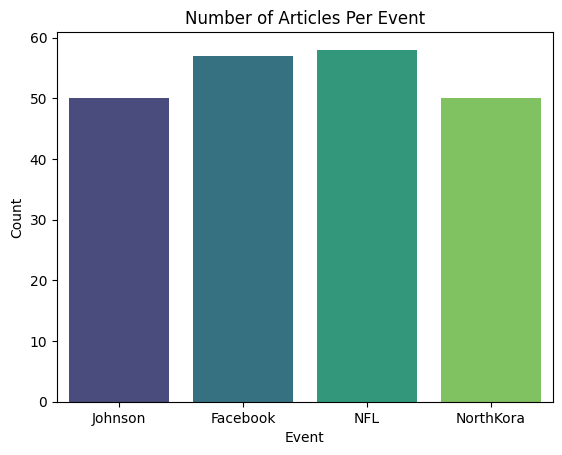

In [ ]:
# Number of articles for each event
print("\nArticles per Event:")
print(df['event'].value_counts())
sns.countplot(x='event', data=df, palette='viridis', hue='event', legend=False)
plt.title("Number of Articles Per Event")
plt.xlabel("Event")
plt.ylabel("Count")
plt.show()

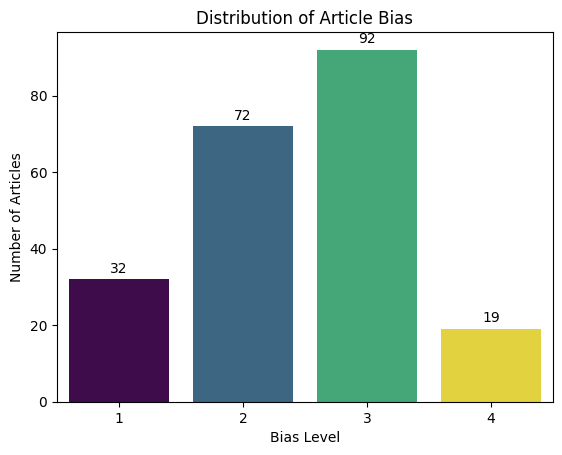

In [ ]:
# Distribution of bias levels across the articles, sorted by bias level
bias_vals = df['article_bias'].value_counts().sort_index()  # Sort by index (bias level)

plt.figure()
ax = sns.barplot(x=bias_vals.index, y=bias_vals.values, palette='viridis', order=bias_vals.index,
                 hue=bias_vals.index, legend=False)

# Add counts on top of each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()  # Get the height of the bar
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1,  # Center the text on the bar
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Article Bias")
plt.xlabel("Bias Level")
plt.ylabel("Number of Articles")
plt.show()


Source Bias Distribution:
source_bias
left-center      59
right            54
right-center     40
left             32
least            20
right-extream    10
Name: count, dtype: int64


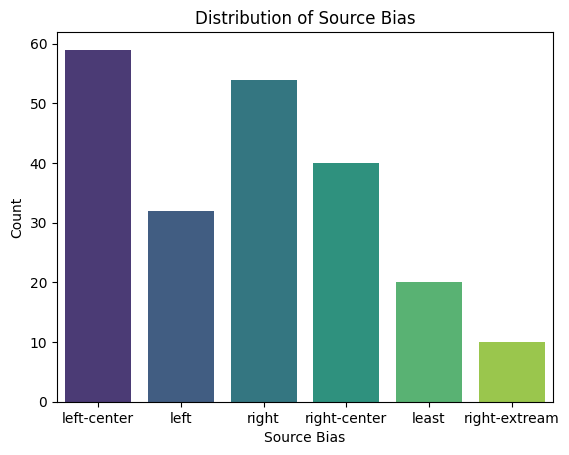

In [ ]:
# Source Bias Distribution
print("\nSource Bias Distribution:")
print(df['source_bias'].value_counts())
sns.countplot(x='source_bias', data=df, palette='viridis', hue='source_bias', legend=False)
plt.title("Distribution of Source Bias")
plt.xlabel("Source Bias")
plt.ylabel("Count")
plt.show()

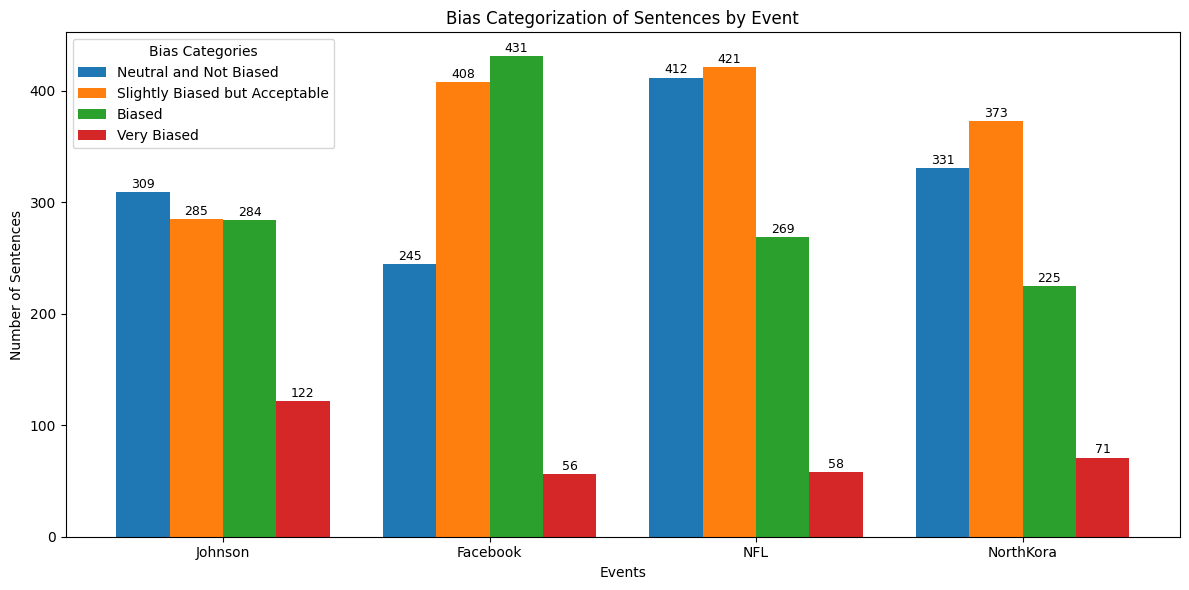

In [ ]:
# Plot distribution of sentences categorized based on their bias level for each event
def categorize_bias(score):
    if score == 1:
        return 'Neutral and Not Biased'
    elif score == 2:
        return 'Slightly Biased but Acceptable'
    elif score == 3:
        return 'Biased'
    elif score == 4:
        return 'Very Biased'

bias_categories = ['Neutral and Not Biased', 'Slightly Biased but Acceptable', 'Biased', 'Very Biased']
sentence_columns = [f'{i}' for i in range(20)]
bias_counts = pd.DataFrame({
    'event': df['event'].unique(),
    **{category: [0]*len(df['event'].unique()) for category in bias_categories}
})

for event in df['event'].unique():
    event_data = df[df['event'] == event]
    for category in bias_categories:
        bias_counts.loc[bias_counts['event'] == event, category] = sum(
            event_data[sentence_columns].map(categorize_bias).stack() == category
        )

x = np.arange(len(bias_counts['event']))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for i, category in enumerate(bias_categories):
    bars = ax.bar(x + i * width, bias_counts[category], width, label=category)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1,  # Adjust position slightly above the bar
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Events')
ax.set_ylabel('Number of Sentences')
ax.set_title('Bias Categorization of Sentences by Event')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(bias_counts['event'])
ax.legend(title='Bias Categories')

plt.tight_layout()
plt.show()


## Clean dataset

In [ ]:
# Drop unnecessary columns
df = df.drop(['date_event', 'source', 'url', 'ref', 'ref_url', 'preknow',
                       'reftitle', 'reftext', 'doctitle', 'docbody'], axis=1)

# Display the first few rows of the filtered dataset (optional)
df.head()

id_event    event  id_article  source_bias  article_bias  t  0  1  2  3  \
0         1  Johnson         1.0  left-center             1  2  3  4  1  1   
1         1  Johnson         1.0  left-center             3  3  2  3  3  3   
2         1  Johnson         1.0  left-center             3  3  2  4  3  3   
3         1  Johnson         1.0  left-center             3  4  1  1  3  1   
4         1  Johnson         2.0         left             4  1  2  1  1  1   

   ...                                                s10  \
0  ...  [10]: Johnson's wife, Rebecca, announced Thurs...   
1  ...  [10]: Johnson's wife, Rebecca, announced Thurs...   
2  ...  [10]: Johnson's wife, Rebecca, announced Thurs...   
3  ...  [10]: Johnson's wife, Rebecca, announced Thurs...   
4  ...  [10]: The accuser, identified as Maranda Richm...   

                                                 s11  \
0  [11]: She spent the day at a funeral home arra...   
1  [11]: She spent the day at a funeral home arra...   
2  [11]: She spent the day at a funeral home arra...   
3  [11]: She spent the day at a funeral home arra...   
4  [11]: She said she was staying in a living are...   

                                                 s12  \
0  [12]: "Dan is gone but the story of his life i...   
1  [12]: "Dan is gone but the story of his life i...   
2  [12]: "Dan is gone but the story of his life i...   
3  [12]: "Dan is gone but the story of his life i...   
4  [12]: The center got its hands on police docum...   

                                                 s13  \
0  [13]: "These high-tech lynchings based on lies...   
1  [13]: "These high-tech lynchings based on lies...   
2  [13]: "These high-tech lynchings based on lies...   
3  [13]: "These high-tech lynchings based on lies...   
4  [13]: Johnson denied the allegations, a day af...   

                                                 s14  \
0  [14]: I've been fighting behind my husband for...   
1  [14]: I've been fighting behind my husband for...   
2  [14]: I've been fighting behind my husband for...   
3  [14]: I've been fighting behind my husband for...   
4  [14]: "This allegation concerning this young g...   

                                                 s15  \
0  [15]: Johnson's death shook his family, friend...   
1  [15]: Johnson's death shook his family, friend...   
2  [15]: Johnson's death shook his family, friend...   
3  [15]: Johnson's death shook his family, friend...   
4  [15]: "As a matter of fact, some of this I hea...   

                                                 s16  \
0                                         [16]: Gov.   
1                                         [16]: Gov.   
2                                         [16]: Gov.   
3                                         [16]: Gov.   
4  [16]: The same day Johnson held a news confere...   

                                                 s17  \
0  [17]: Matt Bevin (R) wrote on Twitter: "My hea...   
1  [17]: Matt Bevin (R) wrote on Twitter: "My hea...   
2  [17]: Matt Bevin (R) wrote on Twitter: "My hea...   
3  [17]: Matt Bevin (R) wrote on Twitter: "My hea...   
4  [17]: Johnson posted a message on his Facebook...   

                                                 s18  \
0  [18]: [White House urges Roy Moore to concede,...   
1  [18]: [White House urges Roy Moore to concede,...   
2  [18]: [White House urges Roy Moore to concede,...   
3  [18]: [White House urges Roy Moore to concede,...   
4       [18]: The post appears to have been deleted.   

                                                 s19  
0  [19]: The tumult began Monday, when the Kentuc...  
1  [19]: The tumult began Monday, when the Kentuc...  
2  [19]: The tumult began Monday, when the Kentuc...  
3  [19]: The tumult began Monday, when the Kentuc...  
4  [19]: "GOD and only GOD knows the truth, nothi...  

[5 rows x 46 columns]

In [ ]:
#Remove sentences labelled by multiple annotators and only keep one
sentence_columns = [f"s{i}" for i in range(20) if f"s{i}" in df.columns]

# Deduplicate based on sentences only
df = df.drop_duplicates(subset=sentence_columns)

df.head()

id_event    event  id_article  source_bias  article_bias  t  0  1  2  3  \
0          1  Johnson         1.0  left-center             1  2  3  4  1  1   
4          1  Johnson         2.0         left             4  1  2  1  1  1   
8          1  Johnson         3.0  left-center             1  2  4  1  2  4   
12         1  Johnson         4.0  left-center             2  3  3  3  1  4   
16         1  Johnson         5.0        right             3  1  2  2  1  4   

    ...                                                s10  \
0   ...  [10]: Johnson's wife, Rebecca, announced Thurs...   
4   ...  [10]: The accuser, identified as Maranda Richm...   
8   ...            [10]: BUT HEAVEN IS MY HOME," he wrote.   
12  ...  [10]: Paul Ham, the chairman of the Bullit Cou...   
16  ...  [10]: In the post, he asked for people to take...   

                                                  s11  \
0   [11]: She spent the day at a funeral home arra...   
4   [11]: She said she was staying in a living are...   
8   [11]: Not long after his death was ruled a sui...   
12  [11]: "The story was based on hearsay: no arre...   
16  [11]: It has won this life, BUT HEAVEN IS MY H...   

                                                  s12  \
0   [12]: "Dan is gone but the story of his life i...   
4   [12]: The center got its hands on police docum...   
8   [12]: KCIP found that Johnson's claim that he ...   
12  [12]: "Back when the Constitution meant someth...   
16       [12]: The post appears to have been removed.   

                                                  s13  \
0   [13]: "These high-tech lynchings based on lies...   
4   [13]: Johnson denied the allegations, a day af...   
8   [13]: And while the Kentucky reporters found r...   
12  [13]: But now, it's just, 'Let's just make som...   
16  [13]: The woman who made the accusations again...   

                                                  s14  \
0   [14]: I've been fighting behind my husband for...   
4   [14]: "This allegation concerning this young g...   
8   [14]: The Wyndham New Yorker Hotel is not a mi...   
12                  [14]: We're in a very bad place."   
16  [14]: She reportedly fell asleep on the couch,...   

                                                  s15  \
0   [15]: Johnson's death shook his family, friend...   
4   [15]: "As a matter of fact, some of this I hea...   
8   [15]: It's about three miles north of Ground Z...   
12  [15]: Others, like Republican Reps. Wesley Mor...   
16  [15]: Richmond said that she reported the epis...   

                                                  s16  \
0                                          [16]: Gov.   
4   [16]: The same day Johnson held a news confere...   
8   [16]: Before his suicide, Johnson made nationa...   
12  [16]: Hoover resigned as the House's Speaker l...   
16            [16]: The case has since been reopened.   

                                                  s17  \
0   [17]: Matt Bevin (R) wrote on Twitter: "My hea...   
4   [17]: Johnson posted a message on his Facebook...   
8   [17]: That didn't stop him from getting electe...   
12  [17]: Michael Skoler, the president of Louisvi...   
16  [17]: Johnson was elected to the State Legisla...   

                                                  s18  \
0   [18]: [White House urges Roy Moore to concede,...   
4        [18]: The post appears to have been deleted.   
8   [18]: Johnson claimed to have a "doctorate of ...   
12  [18]: Other state lawmakers called for kindnes...   
16  [18]: The pastor of Heart of Fire church in Lo...   

                                                  s19  
0   [19]: The tumult began Monday, when the Kentuc...  
4   [19]: "GOD and only GOD knows the truth, nothi...  
8   [19]: The Kentucky Center for Investigative Re...  
12  [19]: On Thursday afternoon, Johnson's widow s...  
16  [19]: But he was mostly out of the spotlight u...  

[5 rows x 46 columns]

## Clean text
Before setting up the models to classify each sentence by its bias, we need to clean the text of these sentences. In particular the following steps need to be applied to "clean" the data:
- converting all text to lowercase
- remove punctuation and unnecessary symbols
- remove stopwords

In [ ]:
# Download stopwords
nltk.download('stopwords')

# Load the stopwords list from NLTK
stop_words = set(stopwords.words('english'))

# "Clean" each sentence
def clean_text(text):
    # Check if the text is a string
    if isinstance(text, str):
        # Remove non-alphabetic characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and whitespace
        # Convert text to lowercase
        text = text.lower()
        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])
    else:
        # If the text is not a string (NaN), return an empty string
        text = ''
    return text

df_cleaned = df.copy()

# Clean the sentences
for i in range(20):
    sentence_column = f's{i}'
    if sentence_column in df.columns:
        df_cleaned[sentence_column] = df_cleaned[sentence_column].apply(clean_text)

df_cleaned[['s0', 's1', 's2', 's3', 's4']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


s0  \
0   louisville dan johnson posted final message fa...   
4   cnn kentucky lawmaker accused sexually assault...   
8   kentucky preacherturnedpolitician killed accus...   
12  kentucky state rep dan johnson died wednesday ...   
16  wife kentucky state rep dan johnson killed wed...   

                                                   s1  \
0                                    appeared goodbye   
4   republican state rep dan johnson found dead si...   
8   state rep dan johnson also declared watched se...   
12  allegations johnson surfaced investigation pub...   
16  dan johnson preacher republican committed suic...   

                                                   s2  \
0   denied accusations tormented family past hours...   
4   johnson drove onto bridge rural area southeast...   
8   johnson also boasted white house chaplain bush...   
12  maranda richmond respond times request comment...   
16  washington according bullitt county sheriff do...   

                                                   s3  \
0   god knows truth nothing way make wrote sincede...   
4   billings ruled johnsons death suicide thursday...   
8   unlikely stories bishop johnson posted web sit...   
12  kentucky center investigative reporting said c...   
16  coroner confirmed johnson died single gunshot ...   

                                                   s4  
0                                cannot handle longer  
4   shortly death johnson posted rambling message ...  
8   tales largely debunked kentucky center investi...  
12  richmond said reported incident louisville police  
16  statement johnsons widow rebecca said running ...

In [ ]:
# Save cleaned df
df_cleaned.to_csv('cleaned_news_bias_dataset.csv')

Train test split

In [ ]:
#train, test = train_test_split(df, test_size=0.2)
train, test = train_test_split(df_cleaned, test_size=0.2)

## Encode sentences
To encode sentences we have experimented with four models: Doc2Vec, SBERT, TF-IDF and Word2vec. The former is used at document level, whereas SentenceBERT is used at the sentence level.

In [ ]:
# Tokenize each sentence in the article
def tokenize_sentence(text):
    tokens = []
    for word in nltk.word_tokenize(text):
        if len(word) < 3:  # Exclude very short words
            continue
        tokens.append(word.lower())  # Lowercase each word
    return tokens

We need to construct tagged sentences for the embedding model

In [ ]:
nltk.download('punkt_tab')

def tokenize_text(dataset_split):
  tagged = []

  for idx, row in dataset_split.iterrows():
      for i in range(20):
          sentence_column = f's{i}'
          if sentence_column in row:
              sentence = row[sentence_column]
              if pd.notna(sentence):  # Check if the sentence is not NaN
                  tokens = tokenize_sentence(sentence)
                  sentence_bias = f'{i}'
                  tag = row[sentence_bias]
                  tagged.append(TaggedDocument(words=tokens, tags=[tag]))
  return tagged
train_tagged = tokenize_text(train)
test_tagged = tokenize_text(test)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Doc2Vec
Doc2Vec is an algoriothm used to encode text; in particular it encodes a whole document of text into a vector of chosen size. Here we are doing classification on the sentence level and not on at document level, so this encoding method may not be the otpimal choice. Anyway, we still inspect how it performs.

We have employed two variations of Doc2Vec:
1. Distributed memory (PV-DM)
2. Distributed bag of words (PV-DBOW)
We will compare them and check which one performs better.

In [ ]:
# Train the Doc2Vec Models
import multiprocessing

# Number of cores for parallel processing
cores = multiprocessing.cpu_count()

models = [
    # PV-DBOW model
    Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores),
    # PV-DM model
    Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores)
]

# Build the vocabulary and train the Doc2Vec models
for model in models:
    model.build_vocab(train_tagged)  # Build vocabulary from tagged sentences
    model.train(train_tagged, total_examples=len(train_tagged), epochs=30)
    model.save(f"doc2vec_sentence_{model.dm}.model")  # Save the trained models


Using the trained models, encode the text from the articles into vectors of length 300.

In [ ]:
# Function to infer sentence vectors
def vec_for_learning(model, tagged_docs):
    features, labels = zip(*[
        (model.infer_vector(doc.words, epochs=20), doc.tags[0])  # Replace 'steps' with 'epochs'
        for doc in tagged_docs
    ])
    return features, labels

# Infer vectors using the PV-DBOW and PV-DM models
# PV-DBOW
train_x_PV_DBOW, train_y_PV_DBOW = vec_for_learning(models[0], train_tagged)
test_x_PV_DBOW, test_y_PV_DBOW = vec_for_learning(models[0], test_tagged)

#PV-DM
train_x_PV_DM, train_y_PV_DM = vec_for_learning(models[1], train_tagged)
test_x_PV_DM, test_y_PV_DM = vec_for_learning(models[1], train_tagged)

`train_x_PV_DBOW` and `train_x_PV_DM` contain the sentence vectors (300-dimensional) from each model.


`train_y_PV_DBOW` and `train_y_PV_DM` contain the corresponding sentence-level bias labels.

### SBERT

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import nltk

# Download NLTK tokenizer
nltk.download('punkt')

# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tokenize each sentence
def tokenize_sentence(text):
    tokens = []
    for word in nltk.word_tokenize(text):
        if len(word) < 3:  # Exclude very short words
            continue
        tokens.append(word.lower())  # Lowercase each word
    return ' '.join(tokens)  # Return a preprocessed sentence as a string

# Encode the sentences in the dataset
def encode_sentences(dataset_split):
    sentence_embeddings = []
    sentence_labels = []

    for idx, row in dataset_split.iterrows():
        for i in range(20):
            sentence_column = f's{i}'
            if sentence_column in row:
                sentence = row[sentence_column]
                if pd.notna(sentence):  # Check if the sentence is not NaN
                    tokens = tokenize_sentence(sentence)
                    embedding = model.encode(tokens)  # Generate SBERT embedding
                    sentence_bias = f'{i}'
                    tag = row[sentence_bias]
                    sentence_embeddings.append(embedding)
                    sentence_labels.append(tag)

    return sentence_embeddings, sentence_labels

# Encode training and test data
train_x_SBERT, train_y_SBERT = encode_sentences(train)
test_x_SBERT, test_y_SBERT = encode_sentences(test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the sentences and labels
train_sentences = [' '.join(doc.words) for doc in train_tagged]
train_labels = [doc.tags[0] for doc in train_tagged]

test_sentences = [' '.join(doc.words) for doc in test_tagged]
test_labels = [doc.tags[0] for doc in test_tagged]

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Transform the sentences into TF-IDF features
train_x_tfidf = tfidf_vectorizer.fit_transform(train_sentences).toarray()  # Convert sparse matrix to dense array
test_x_tfidf = tfidf_vectorizer.transform(test_sentences).toarray()

# Labels
train_y_tfidf = train_labels
test_y_tfidf = test_labels

### Word2Vec

In [ ]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
print(path)

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
def sentence_to_vec(sentence, model):
    words = [word for word in sentence if word in model.key_to_index]
    return np.mean([model[word] for word in words], axis=0) if words else np.zeros(model.vector_size)

train_x_word2vec = np.array([sentence_to_vec(doc.words, word2vec) for doc in train_tagged])
test_x_word2vec = np.array([sentence_to_vec(doc.words, word2vec) for doc in test_tagged])
# Labels
train_y_word2vec = train_labels
test_y_word2vec = test_labels

## Classification ML Models

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

#Helper function for calculating accuracy on the test set.
def get_results(true, pred):
  report = classification_report(true, pred, output_dict=True, zero_division=0)
  return report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']

### Naive Bayes

In [ ]:
def naive_bayes(train_x, train_y, test_x, test_y):
  bayes = GaussianNB()
  bayes.fit(train_x, train_y)
  results = get_results(test_y, bayes.predict(test_x))
  return results

# With Doc2Vec
results1 = naive_bayes(train_x_PV_DBOW, train_y_PV_DBOW, test_x_PV_DBOW, test_y_PV_DBOW)
print("Doc2Vec (PV-DBOW):")
print("Accuracy: ", results1[0])
print("Precision: ", results1[1])
print("Recall: ", results1[2])
print("F1-score: ", results1[3])

# With Doc2Vec
results2 = naive_bayes(train_x_PV_DM, train_y_PV_DM, test_x_PV_DM, test_y_PV_DM)
print("\nDoc2Vec (PV-DM):")
print("Accuracy: ", results2[0])
print("Precision: ", results2[1])
print("Recall: ", results2[2])
print("F1-score: ", results2[3])

# With SBERT
results3 = naive_bayes(train_x_SBERT, train_y_SBERT, test_x_SBERT, test_y_SBERT)
print("\nSBERT:")
print("Accuracy: ", results3[0])
print("Precision: ", results3[1])
print("Recall: ", results3[2])
print("F1-score: ", results3[3])

# With TF-IDF
results4 = naive_bayes(train_x_tfidf, train_y_tfidf, test_x_tfidf, test_y_tfidf)
print("\nTF-IDF:")
print("Accuracy: ", results4[0])
print("Precision: ", results4[1])
print("Recall: ", results4[2])
print("F1-score: ", results4[3])

# With wav2vec
results5 = naive_bayes(train_x_word2vec, train_y_word2vec, test_x_word2vec, test_y_word2vec)
print("\nword2vec:")
print("Accuracy: ", results5[0])
print("Precision: ", results5[1])
print("Recall: ", results5[2])
print("F1-score: ", results5[3])


Doc2Vec (PV-DBOW):
Accuracy:  0.375
Precision:  0.4225714285714286
Recall:  0.375
F1-score:  0.3561328903654485

Doc2Vec (PV-DM):
Accuracy:  0.5458333333333333
Precision:  0.6308262365475825
Recall:  0.5458333333333333
F1-score:  0.5618930443257033

SBERT:
Accuracy:  0.415
Precision:  0.5136282828282828
Recall:  0.415
F1-score:  0.404073221275616

TF-IDF:
Accuracy:  0.295
Precision:  0.31941345669606536
Recall:  0.295
F1-score:  0.30339279360561155

word2vec:
Accuracy:  0.265
Precision:  0.2798520465437589
Recall:  0.265
F1-score:  0.2674821424528908


Doc2Vec (PV-DBOW):
- Accuracy:  0.375
- Precision:  0.4225714285714286
- Recall:  0.375
- F1-score:  0.3561328903654485

Doc2Vec (PV-DM):
- Accuracy:  0.5458333333333333
- Precision:  0.6308262365475825
- Recall:  0.5458333333333333
- F1-score:  0.5618930443257033

SBERT:
- Accuracy:  0.415
- Precision:  0.5136282828282828
- Recall:  0.415
- F1-score:  0.404073221275616

TF-IDF:
- Accuracy:  0.295
- Precision:  0.31941345669606536
- Recall:  0.295
- F1-score:  0.30339279360561155

word2vec:
- Accuracy:  0.265
- Precision:  0.2798520465437589
- Recall:  0.265
- F1-score:  0.2674821424528908


### Random Forest Classifier

In [ ]:
# Create random forests with 100 decision trees
def random_forest(train_x, train_y, test_x, test_y):
  forest = RandomForestClassifier(n_estimators=100)

  forest.fit(train_x,train_y)
  return get_results(test_y,forest.predict(test_x))

# With Doc2Vec
results1 = random_forest(train_x_PV_DBOW, train_y_PV_DBOW, test_x_PV_DBOW, test_y_PV_DBOW)
print("Doc2Vec (PV-DBOW):")
print("Accuracy: ", results1[0])
print("Precision: ", results1[1])
print("Recall: ", results1[2])
print("F1-score: ", results1[3])

# With Doc2Vec
results2 = random_forest(train_x_PV_DM, train_y_PV_DM, test_x_PV_DM, test_y_PV_DM)
print("\nDoc2Vec (PV-DM):")
print("Accuracy: ", results2[0])
print("Precision: ", results2[1])
print("Recall: ", results2[2])
print("F1-score: ", results2[3])

# With SBERT
results3 = random_forest(train_x_SBERT, train_y_SBERT, test_x_SBERT, test_y_SBERT)
print("\nSBERT:")
print("Accuracy: ", results3[0])
print("Precision: ", results3[1])
print("Recall: ", results3[2])
print("F1-score: ", results3[3])

# With TF-IDF
results4 = random_forest(train_x_tfidf, train_y_tfidf, test_x_tfidf, test_y_tfidf)
print("\nTF-IDF: ")
print("Accuracy: ", results4[0])
print("Precision: ", results4[1])
print("Recall: ", results4[2])
print("F1-score: ", results4[3])

# With wav2vec
results5 = random_forest(train_x_word2vec, train_y_word2vec, test_x_word2vec, test_y_word2vec)
print("\nword2vec:")
print("Accuracy: ", results5[0])
print("Precision: ", results5[1])
print("Recall: ", results5[2])
print("F1-score: ", results5[3])

Doc2Vec (PV-DBOW):
Accuracy:  0.33
Precision:  0.3146446243814665
Recall:  0.33
F1-score:  0.3208030990393874

Doc2Vec (PV-DM):
Accuracy:  0.7458333333333333
Precision:  0.7536018796495351
Recall:  0.7458333333333333
F1-score:  0.7347769335008958

SBERT:
Accuracy:  0.4
Precision:  0.33841055131309367
Recall:  0.4
F1-score:  0.35342330553158857

TF-IDF: 
Accuracy:  0.4
Precision:  0.35154455280486785
Recall:  0.4
F1-score:  0.37098347472960475

word2vec:
Accuracy:  0.405
Precision:  0.33885746606334843
Recall:  0.405
F1-score:  0.3465884336617681


Doc2Vec (PV-DBOW):
- Accuracy:  0.33
- Precision:  0.3146446243814665
- Recall:  0.33
- F1-score:  0.3208030990393874

Doc2Vec (PV-DM):
- Accuracy:  0.7458333333333333
- Precision:  0.7536018796495351
- Recall:  0.7458333333333333
- F1-score:  0.7347769335008958

SBERT:
- Accuracy:  0.4
- Precision:  0.33841055131309367
- Recall:  0.4
- F1-score:  0.35342330553158857

TF-IDF:
- Accuracy:  0.4
- Precision:  0.35154455280486785
- Recall:  0.4
- F1-score:  0.37098347472960475

word2vec:
- Accuracy:  0.405
- Precision:  0.33885746606334843
- Recall:  0.405
- F1-score:  0.3465884336617681

### Support Vector Classifier

In [ ]:
def support_vector(train_x, train_y, test_x, test_y):
  svc = SVC()

  svc.fit(train_x,train_y)
  return get_results(test_y,svc.predict(test_x))

# With Doc2Vec
results1 = support_vector(train_x_PV_DBOW, train_y_PV_DBOW, test_x_PV_DBOW, test_y_PV_DBOW)
print("Doc2Vec (PV-DBOW):")
print("Accuracy: ", results1[0])
print("Precision: ", results1[1])
print("Recall: ", results1[2])
print("F1-score: ", results1[3])

# With Doc2Vec
results2 = support_vector(train_x_PV_DM, train_y_PV_DM, test_x_PV_DM, test_y_PV_DM)
print("\nDoc2Vec (PV-DM):")
print("Accuracy: ", results2[0])
print("Precision: ", results2[1])
print("Recall: ", results2[2])
print("F1-score: ", results2[3])

# With SBERT
results3 = support_vector(train_x_SBERT, train_y_SBERT, test_x_SBERT, test_y_SBERT)
print("\nSBERT:")
print("Accuracy: ", results3[0])
print("Precision: ", results3[1])
print("Recall: ", results3[2])
print("F1-score: ", results3[3])

# With TF-IDF
results4 = support_vector(train_x_tfidf, train_y_tfidf, test_x_tfidf, test_y_tfidf)
print("\nTF-IDF: ")
print("Accuracy: ", results4[0])
print("Precision: ", results4[1])
print("Recall: ", results4[2])
print("F1-score: ", results4[3])

# With wav2vec
results5 = support_vector(train_x_word2vec, train_y_word2vec, test_x_word2vec, test_y_word2vec)
print("\nword2vec:")
print("Accuracy: ", results5[0])
print("Precision: ", results5[1])
print("Recall: ", results5[2])
print("F1-score: ", results5[3])

Doc2Vec (PV-DBOW):
Accuracy:  0.395
Precision:  0.32819979351826917
Recall:  0.395
F1-score:  0.3545666982024598

Doc2Vec (PV-DM):
Accuracy:  0.6305555555555555
Precision:  0.5943274087024087
Recall:  0.6305555555555555
F1-score:  0.6038355021688355

SBERT:
Accuracy:  0.405
Precision:  0.34314082556708286
Recall:  0.405
F1-score:  0.3552699838104947

TF-IDF: 
Accuracy:  0.425
Precision:  0.40673953488372094
Recall:  0.425
F1-score:  0.34309685479410246

word2vec:
Accuracy:  0.38
Precision:  0.31451238390092884
Recall:  0.38
F1-score:  0.30837301587301585


Doc2Vec (PV-DBOW):
- Accuracy:  0.395
- Precision:  0.32819979351826917
- Recall:  0.395
- F1-score:  0.3545666982024598

Doc2Vec (PV-DM):
- Accuracy:  0.6305555555555555
- Precision:  0.5943274087024087
- Recall:  0.6305555555555555
- F1-score:  0.6038355021688355

SBERT:
- Accuracy:  0.405
- Precision:  0.34314082556708286
- Recall:  0.405
- F1-score:  0.3552699838104947

TF-IDF:
- Accuracy:  0.425
- Precision:  0.40673953488372094
- Recall:  0.425
- F1-score:  0.34309685479410246

word2vec:
- Accuracy:  0.38
- Precision:  0.31451238390092884
- Recall:  0.38
- F1-score:  0.30837301587301585

### Deep Learning

In [ ]:
import numpy as np

def prepare_data_keras(train_x,train_y,test_x,test_y):
  tx,ty,tex,tey = np.asarray(train_x), np.asarray(train_y), np.asarray(test_x), np.asarray(test_y)
  ty = np.asarray(list([np.asarray([0,0,1]) if el == 0 else np.asarray([0,1,0])
    if el == 1 else np.asarray([1,0,0]) for el in ty]))
  tey = np.asarray(list([np.asarray([0,0,1]) if el == 0 else np.asarray([0,1,0])
    if el == 1 else np.asarray([1,0,0]) for el in tey]))
  return tx,ty,tex,tey

In [ ]:
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  # Ensure y_true is float32
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  # Ensure y_true is float32
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))



In [ ]:
from tensorflow.keras import backend as K

def deep_learning(train_x,train_y,test_x,test_y, dim):
  train_x,train_y,test_x,test_y = prepare_data_keras(train_x,train_y,test_x,test_y)

  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(dim,)))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                metrics=['acc',recall_m,precision_m,f1_m])

  # fit with 90 epochs
  history = model.fit(train_x,train_y,epochs=90,validation_data=(test_x,test_y), verbose=1)

  # evaluate the model
  return history, model.evaluate(test_x, test_y, batch_size=128)

history1, eval1 = deep_learning(train_x_PV_DBOW, train_y_PV_DBOW, test_x_PV_DBOW, test_y_PV_DBOW, 300)
print("Doc2Vec (PV-DBOW): ", eval1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - acc: 0.6356 - f1_m: 0.0000e+00 - loss: 1.0666 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 0.9831 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6986 - f1_m: 0.0531 - loss: 0.9393 - precision_m: 0.2380 - recall_m: 0.0331 - val_acc: 0.6919 - val_f1_m: 0.5239 - val_loss: 0.8529 - val_precision_m: 0.7476 - val_recall_m: 0.4130
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7053 - f1_m: 0.6212 - loss: 0.7997 - precision_m: 0.7919 - recall_m: 0.5172 - val_acc: 0.6919 - val_f1_m: 0.6647 - val_loss: 0.7581 - val_precision_m: 0.7490 - val_recall_m: 0.6076
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7028 - f1_m: 0.6828 - loss: 0.7045 - precision_m: 0.7636 - recall_m: 0.6195 - val_acc: 0.6919 - val_f1_m: 0.6737 - val_loss: 0.7114 - val_precision_m: 0.7412 - val_recall_m: 0.6262
Epoch 

Doc2Vec (PV-DBOW): [0.7720224857330322, 0.7513812184333801, 0.8147847652435303, 0.817337691783905, 0.8160561919212341]

In [ ]:
history2, eval2 = deep_learning(train_x_PV_DM, train_y_PV_DM, test_x_PV_DM, test_y_PV_DM, 300)
print("Doc2Vec (PV-DM): ", eval2)

Epoch 1/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - acc: 0.6908 - f1_m: 0.0037 - loss: 1.0434 - precision_m: 0.0350 - recall_m: 0.0020 - val_acc: 0.7000 - val_f1_m: 0.1674 - val_loss: 0.9376 - val_precision_m: 0.7086 - val_recall_m: 0.0992
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.7092 - f1_m: 0.3365 - loss: 0.9008 - precision_m: 0.8030 - recall_m: 0.2250 - val_acc: 0.7000 - val_f1_m: 0.5888 - val_loss: 0.8100 - val_precision_m: 0.7746 - val_recall_m: 0.4815
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6954 - f1_m: 0.6182 - loss: 0.7868 - precision_m: 0.7720 - recall_m: 0.5186 - val_acc: 0.7000 - val_f1_m: 0.6486 - val_loss: 0.7347 - val_precision_m: 0.7602 - val_recall_m: 0.5723
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6842 - f1_m: 0.6396 - loss: 0.7353 - precision_m: 0.7363 - recall_m: 0.5674 - val_acc: 0.7000 - val_f1_m: 0.6691 - val_loss: 0.6952 - val_precision_m: 0.7536 - val_recall_m: 0.6085
Epoch 5/90
108/108 ━━━━━━━━━━━━

Doc2Vec (PV-DM): [0.34298208355903625, 0.851739764213562, 0.8671875, 0.8761124610900879, 0.8716104626655579]

In [ ]:
history3, eval3 = deep_learning(train_x_SBERT, train_y_SBERT, test_x_SBERT, test_y_SBERT, 384)
print("SBERT: ", eval3)

Epoch 1/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - acc: 0.4721 - f1_m: 0.0000e+00 - loss: 1.0889 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 1.0479 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6877 - f1_m: 0.0000e+00 - loss: 1.0315 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 0.9850 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6873 - f1_m: 7.4493e-04 - loss: 0.9638 - precision_m: 0.0109 - recall_m: 3.8824e-04 - val_acc: 0.6919 - val_f1_m: 0.0484 - val_loss: 0.9072 - val_precision_m: 0.3148 - val_recall_m: 0.0278
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7070 - f1_m: 0.2059 - loss: 0.8739 - precision_m: 0.7829 - recall_m: 0.1316 - val_acc: 0.6919 - val_f1_m: 0.5746 - val_loss: 0.8270 - val_precision_m: 0.735

SBERT: [0.5460772514343262, 0.7955800890922546, 0.8499410152435303, 0.8499410152435303, 0.8499410152435303]


In [ ]:
# With TF-IDF
acc4 = deep_learning(train_x_tfidf, train_y_tfidf, test_x_tfidf, test_y_tfidf, train_x_tfidf.shape[1])
print("TF-IDF: ", acc4)

Epoch 1/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - acc: 0.4657 - f1_m: 0.0000e+00 - loss: 1.0847 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6767 - val_f1_m: 0.0000e+00 - val_loss: 1.0603 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.6822 - f1_m: 0.0000e+00 - loss: 1.0487 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 1.0149 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6963 - f1_m: 0.0000e+00 - loss: 0.9986 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 0.9557 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6975 - f1_m: 0.0000e+00 - loss: 0.9344 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss

TF-IDF: [0.552458643913269, 0.7955800890922546, 0.8499410152435303, 0.8499410152435303, 0.8499410152435303]

In [ ]:
# With wav2vec
acc5 = deep_learning(train_x_word2vec, train_y_word2vec, test_x_word2vec, test_y_word2vec, train_x_word2vec.shape[1])
print("word2vec: ", acc5)

Epoch 1/90


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - acc: 0.6767 - f1_m: 0.0000e+00 - loss: 1.0656 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6919 - val_f1_m: 0.0000e+00 - val_loss: 1.0093 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.7053 - f1_m: 0.0045 - loss: 0.9884 - precision_m: 0.0620 - recall_m: 0.0024 - val_acc: 0.6919 - val_f1_m: 0.1033 - val_loss: 0.9189 - val_precision_m: 0.5888 - val_recall_m: 0.0613
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6873 - f1_m: 0.2701 - loss: 0.9052 - precision_m: 0.6331 - recall_m: 0.1921 - val_acc: 0.6919 - val_f1_m: 0.6942 - val_loss: 0.8339 - val_precision_m: 0.7383 - val_recall_m: 0.6622
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7118 - f1_m: 0.7079 - loss: 0.8106 - precision_m: 0.7435 - recall_m: 0.6767 - val_acc: 0.6919 - val_f1_m: 0.6968 - val_loss: 0.7709 - val_precision_m: 0.7385 - val_recall_m: 0.6668
Epoch 5/90
108/108

word2vec:  [0.5268440842628479, 0.7900552749633789, 0.8460347652435303, 0.8460347652435303, 0.8460347652435303]

# BertForSequenceClassification

Reference: [huggingface](https://huggingface.co/docs/transformers/model_doc/bert#bertforsequenceclassification)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import re

import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error, mean_absolute_error
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

## Pre-process the dataset

In [ ]:
# df = pd.read_csv('/content/Sora_LREC2020_biasedsentences.csv', header=0)
df = pd.read_csv('/content/cleaned_news_bias_dataset.csv', header=0)

print(df.shape)
df.head()

(46, 47)


Unnamed: 0  id_event    event  id_article  source_bias  article_bias  t  0  \
0           0         1  Johnson         1.0  left-center             1  2  3   
1           4         1  Johnson         2.0         left             4  1  2   
2           8         1  Johnson         3.0  left-center             1  2  4   
3          12         1  Johnson         4.0  left-center             2  3  3   
4          16         1  Johnson         5.0        right             3  1  2   

   1  2  ...                                                s10  \
0  4  1  ...  johnsons wife rebecca announced thursday plans...   
1  1  1  ...                accuser identified maranda richmond   
2  1  2  ...                                  heaven home wrote   
3  3  1  ...  paul ham chairman bullit county gop criticized...   
4  2  1  ...  post asked people take care wife wrote posttra...   

                                                 s11  \
0  spent day funeral home arranging husbands serv...   
1  said staying living area louisvilles heart fir...   
2  long death ruled suicide johnsons wife rebecca...   
3  story based hearsay arrest conviction jail tim...   
4                                   life heaven home   

                                                 s12  \
0  dan gone story life far rebecca johnson said a...   
1  center got hands police documents accusations ...   
2  kcip found johnsons claim brought dead woman b...   
3  back constitution meant something man could st...   
4                               post appears removed   

                                                 s13  \
0  hightech lynchings based lies halftruths cant ...   
1  johnson denied allegations day center publishe...   
2  kentucky reporters found records placed johnso...   
3                          lets make accusations run   
4  woman made accusations dan johnson maranda ric...   

                                                 s14  \
0         ive fighting behind husband years fight go   
1  allegation concerning young girl absolutely me...   
2   wyndham new yorker hotel mile away johnson wrote   
3                                          bad place   
4  reportedly fell asleep couch early hours jan c...   

                                                 s15  \
0  johnsons death shook family friends constituen...   
1  matter fact heard yesterday first time read story   
2    three miles north ground zero midtown manhattan   
3  others like republican reps wesley morgan jeff...   
4  richmond said reported episode louisville poli...   

                                                 s16  \
0                                                gov   
1  day johnson held news conference louisville de...   
2  suicide johnson made national news campaign po...   
3  hoover resigned houses speaker last month kept...   
4                                case since reopened   

                                                 s17  \
0  matt bevin r wrote twitter heart breaks family...   
1  johnson posted message facebook page wednesday...   
2  didnt stop getting elected last year overwhelm...   
3  michael skoler president louisville public med...   
4  johnson elected state legislature part wave re...   

                                                 s18  \
0  white house urges roy moore concede supporters...   
1                               post appears deleted   
2  johnson claimed doctorate divinity des moines ...   
3  state lawmakers called kindness wake johnsons ...   
4  pastor heart fire church louisville johnson sp...   

                                                 s19  
0  tumult began monday kentucky center investigat...  
1               god god knows truth nothing way make  
2  kentucky center investigative reporting found ...  
3  thursday afternoon johnsons widow said wanted ...  
4         mostly spotlight investigative story broke  

[5 rows x 47 columns]

In [ ]:
# Identify sentence and label columns
sentence_cols = [f's{i}' for i in range(20)]
label_cols = [f'{i}' for i in range(20)]

sentences_long = df.melt(
    id_vars=['id_article'],
    value_vars=sentence_cols,
    var_name='sentence_number',
    value_name='text'
)

labels_long = df.melt(
    id_vars=['id_article'],
    value_vars=label_cols,
    var_name='label_number',
    value_name='label'
)

sentences_long = sentences_long.sort_values(['id_article', 'sentence_number']).reset_index(drop=True)
labels_long = labels_long.sort_values(['id_article', 'label_number']).reset_index(drop=True)
combined_df = pd.concat([sentences_long, labels_long['label']], axis=1)

print(combined_df.shape)

combined_df.head()

(920, 4)


id_article sentence_number  \
0         1.0              s0   
1         1.0              s1   
2         1.0             s10   
3         1.0             s11   
4         1.0             s12   

                                                text  label  
0  louisville dan johnson posted final message fa...      3  
1                                   appeared goodbye      4  
2  johnsons wife rebecca announced thursday plans...      2  
3  spent day funeral home arranging husbands serv...      4  
4  dan gone story life far rebecca johnson said a...      2

In [ ]:
print(combined_df['text'].apply(type).value_counts())

nan_count = combined_df['text'].isna().sum()
print(f"Number of NaN entries in 'text' column: {nan_count}")

# Drop rows where 'text' is NaN
combined_df_cleaned = combined_df.dropna(subset=['text']).reset_index(drop=True)

nan_count_after = combined_df_cleaned['text'].isna().sum()
print(f"Number of NaN entries after cleaning: {nan_count_after}")

# Check for NaN in 'label' column
nan_labels = combined_df['label'].isna().sum()
print(f"Number of NaN labels: {nan_labels}")

text
<class 'str'>      841
<class 'float'>     79
Name: count, dtype: int64
Number of NaN entries in 'text' column: 79
Number of NaN entries after cleaning: 0
Number of NaN labels: 0


In [ ]:
def clean_text(text):
    # Use regex to remove patterns like [0]:, [1]:, etc., at the beginning of the string
    cleaned = re.sub(r'^\[\d+\]:\s*', '', text)
    return cleaned

# Apply the cleaning function to the 'text' column
combined_df_cleaned['text'] = combined_df_cleaned['text'].apply(clean_text)

for i in range(10):
  print(combined_df_cleaned.iloc[i]["sentence_number"])
  print(combined_df_cleaned.iloc[i]["text"])
  print(combined_df_cleaned.iloc[i]["label"])

s0
louisville dan johnson posted final message facebook friends family wednesday afternoon
3
s1
appeared goodbye
4
s10
johnsons wife rebecca announced thursday plans replace state legislature
2
s11
spent day funeral home arranging husbands service consoling relatives continuing best fighting family said david adams family friend spokesman
4
s12
dan gone story life far rebecca johnson said adams
2
s13
hightech lynchings based lies halftruths cant allowed win day
3
s14
ive fighting behind husband years fight go
4
s15
johnsons death shook family friends constituents members church kentuckys political elite immediately expressing sadness
2
s16
gov
2
s17
matt bevin r wrote twitter heart breaks family may god indeed shed grace us sen rand paul rky said tweet cannot imagine pain heartbreak family dealing
4


In [ ]:
# Map labels: 1->0, 2->1, 3->2, 4->3
combined_df_cleaned['label'] = combined_df_cleaned['label'] - 1
combined_df_cleaned['label'] = combined_df_cleaned['label'].astype(int)

print("Unique labels after mapping:", combined_df_cleaned['label'].unique())

Unique labels after mapping: [2 3 1 0]


## Train/test split

In [ ]:
print(combined_df_cleaned['label'].apply(type).value_counts())

label
<class 'int'>    841
Name: count, dtype: int64


In [ ]:
train_val_df, test_df = train_test_split(
    combined_df_cleaned, test_size=0.2, random_state=42, stratify=combined_df_cleaned['label']
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

print("Unique labels in training set after mapping:", train_df['label'].unique())
print("Unique labels in validation set after mapping:", val_df['label'].unique())
print("Unique labels in test set after mapping:", test_df['label'].unique())

Training samples: 604
Validation samples: 68
Testing samples: 169
Unique labels in training set after mapping: [1 3 0 2]
Unique labels in validation set after mapping: [0 2 1 3]
Unique labels in test set after mapping: [1 0 2 3]


## Tokenize and convert to huggingface dataset

In [ ]:
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Convert labels to float for a regression problem
# train_df['label'] = train_df['label'].astype(float)
# val_df['label'] = val_df['label'].astype(float)
# test_df['label'] = test_df['label'].astype(float)

In [ ]:
# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

In [ ]:
# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

## Train the model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint,
    # num_labels=1,  # num_labels=1 for regression
    num_labels=4,
    id2label={0: "1", 1: "2", 2: "3", 3: "4"},
    label2id={"1": 0, "2": 1, "3": 2, "4": 3}
)

print("Model Configuration:")
print("Number of labels:", model.config.num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Configuration:
Number of labels: 4


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # metric_for_best_model="eval_mse",
    greater_is_better=True,
    report_to=[],
    # no_cuda=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


def compute_metrics_regression(p):
    preds = p.predictions.squeeze()
    labels = p.label_ids
    mse = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {
        'mse': mse,
        'mae': mae,
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # compute_metrics=compute_metrics_regression,
    tokenizer=tokenizer
)

<ipython-input-22-742385b95e84>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

TrainOutput(global_step=380, training_loss=0.9451977064735011, metrics={'train_runtime': 252.5265, 'train_samples_per_second': 23.918, 'train_steps_per_second': 1.505, 'total_flos': 397304827944960.0, 'train_loss': 0.9451977064735011, 'epoch': 10.0})

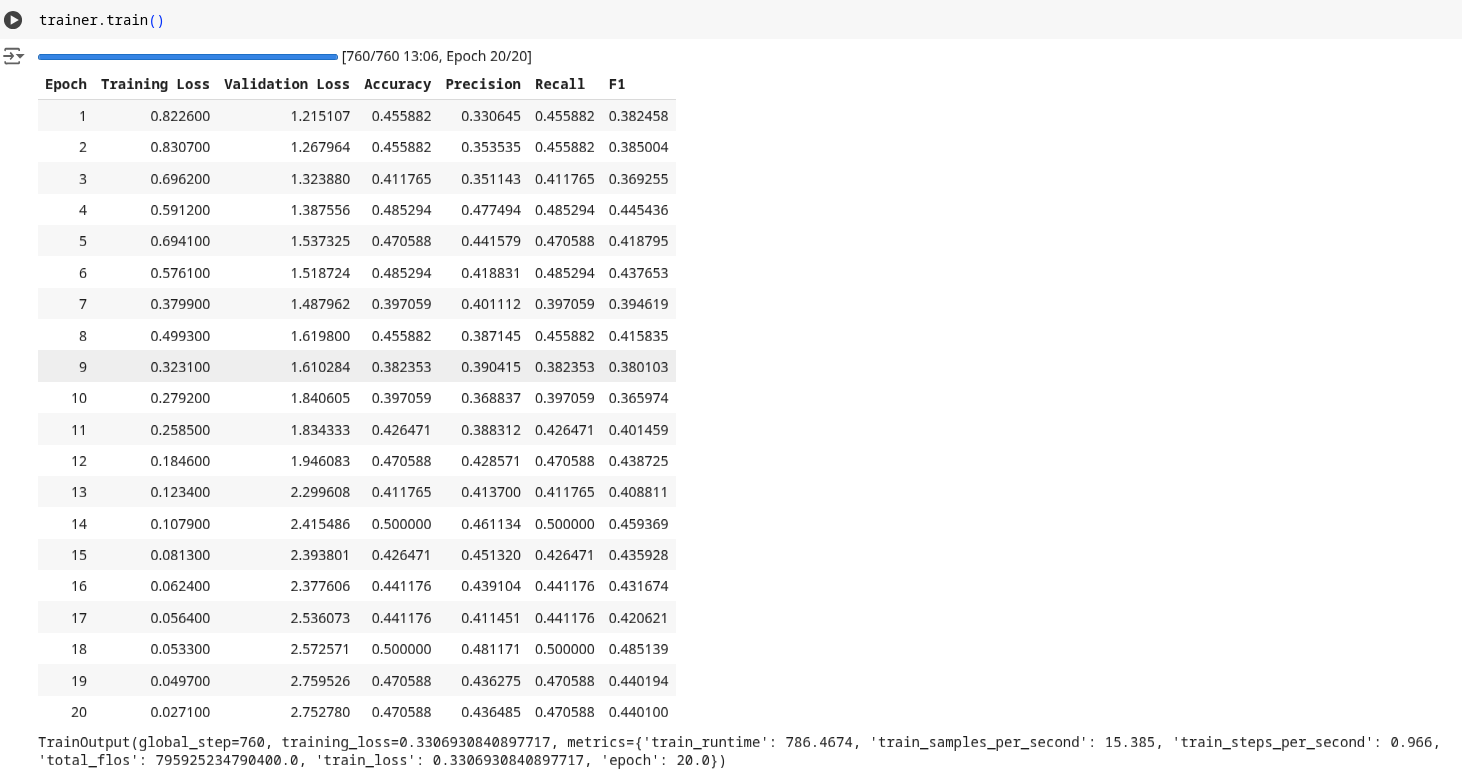![image.png](
)

In [ ]:
trainer.evaluate()

{'eval_loss': 1.214286208152771,
 'eval_accuracy': 0.4411764705882353,
 'eval_precision': 0.3198240935432586,
 'eval_recall': 0.4411764705882353,
 'eval_f1': 0.3704071071243747,
 'eval_runtime': 0.5573,
 'eval_samples_per_second': 122.011,
 'eval_steps_per_second': 5.383,
 'epoch': 10.0}

In [ ]:
results = trainer.evaluate(test_dataset)
print("Test Set Results:")
print(results)

Test Set Results:
{'eval_loss': 1.2445635795593262, 'eval_accuracy': 0.4260355029585799, 'eval_precision': 0.31038061638775355, 'eval_recall': 0.4260355029585799, 'eval_f1': 0.3581061385447507, 'eval_runtime': 1.2014, 'eval_samples_per_second': 140.664, 'eval_steps_per_second': 4.994, 'epoch': 10.0}


In [ ]:
# prediction_output = trainer.predict(test_dataset)

# # Extract logits and true labels
# logits = prediction_output.predictions
# true_labels = prediction_output.label_ids

# for i in range(100):
#     print(f"Actual: {true_labels[i]}, Predicted: {logits[i]}")

In [ ]:
# Save the model
trainer.save_model()  # Saves to output_dir
tokenizer.save_pretrained(training_args.output_dir)

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

## SHAP Pipeline

ref: [SHAP Tutorial](https://colab.research.google.com/github/ml6team/quick-tips/blob/main/nlp/2021_04_22_shap_for_huggingface_transformers/explainable_transformers_using_shap.ipynb#scrollTo=Ocd9majYrupz)

In [ ]:
!pip install --quiet shap

In [ ]:
from transformers import TextClassificationPipeline
import shap
import random

In [ ]:
# Load previously fine-tuned model
ft_tokenizer = BertTokenizer.from_pretrained("./results")
ft_model  = BertForSequenceClassification.from_pretrained("./results")

In [ ]:
pipe = TextClassificationPipeline(model=ft_model, tokenizer=ft_tokenizer, return_all_scores=True)

# Neutral and unbiased background texts
background_texts = [
    "The local community organized a charity event to support education.",
    "Advancements in technology have transformed modern industries.",
    "Health experts recommend regular exercise for a balanced lifestyle.",
    "The annual festival attracts visitors from all over the region.",
    "Economic policies are being re-evaluated to foster growth."
]

explainer = shap.Explainer(pipe)


def score_and_visualize(text):
  prediction = pipe([text])
  print(prediction[0])

  shap_values = explainer([text])
  shap.plots.text(shap_values)

Device set to use cuda:0
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
score_and_visualize('After many years of training, I finally succeeded in achieving '
                    'my black belt in machine learning. The road was very rough but '
                    'I could not be more happy with the result!')

[{'label': '1', 'score': 0.12581302225589752}, {'label': '2', 'score': 0.535067617893219}, {'label': '3', 'score': 0.21281667053699493}, {'label': '4', 'score': 0.12630261480808258}]


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.09s/it]               


In [ ]:
shuffled_test_dataset = test_dataset.shuffle(seed=42)

# Select the first three samples
sampled_dataset = shuffled_test_dataset.select(range(3))

test_texts = [sample['text'] for sample in sampled_dataset]

print("Sampled Texts:")
for idx, text in enumerate(test_texts, start=1):
    print(f"Sample {idx}: {text}\n")

Sampled Texts:
Sample 1: actual task hand dealing north korea

Sample 2: president realistic well said

Sample 3: even though campaign went ahead decided cooperate scl



In [ ]:
for sample in sampled_dataset:
  text = sample['text']
  label = sample['label']

  print("Ground truth label: ", label)
  print("\n")
  score_and_visualize(text)

Ground truth label:  1


[{'label': '1', 'score': 0.226242333650589}, {'label': '2', 'score': 0.4334328770637512}, {'label': '3', 'score': 0.2692459523677826}, {'label': '4', 'score': 0.07107888907194138}]


Ground truth label:  2


[{'label': '1', 'score': 0.16475385427474976}, {'label': '2', 'score': 0.4899066090583801}, {'label': '3', 'score': 0.2546761929988861}, {'label': '4', 'score': 0.09066332131624222}]


Ground truth label:  1


[{'label': '1', 'score': 0.26115646958351135}, {'label': '2', 'score': 0.23084332048892975}, {'label': '3', 'score': 0.43356218934059143}, {'label': '4', 'score': 0.07443808019161224}]


# SHAP Bar Plot

# Shap values for a full test set

In [ ]:
shap_values = explainer(test_dataset["text"])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer:   1%|          | 1/169 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 4/169 [00:33<16:33,  6.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 5/169 [00:45<21:52,  8.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 7/169 [00:57<17:48,  6.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 9/169 [01:07<14:56,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 11/169 [01:18<13:51,  5.26s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 12/169 [01:25<14:29,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 14/169 [01:37<14:18,  5.54s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 15/169 [01:44<15:42,  6.12s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 16/169 [01:50<15:22,  6.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 19/169 [02:05<12:10,  4.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 20/169 [02:14<15:31,  6.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 22/169 [02:25<13:35,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█▉        | 33/169 [02:53<06:58,  3.07s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 34/169 [02:58<08:25,  3.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 35/169 [03:07<11:28,  5.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 36/169 [03:17<14:45,  6.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 38/169 [03:28<12:51,  5.89s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 40/169 [03:35<09:12,  4.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 41/169 [03:42<10:56,  5.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 48/169 [03:59<05:10,  2.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 54/169 [04:16<05:06,  2.66s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 57/169 [04:23<03:51,  2.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 61/169 [04:37<04:08,  2.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 66/169 [04:55<05:03,  2.95s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 71/169 [05:09<03:34,  2.19s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 72/169 [05:16<05:53,  3.65s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 76/169 [05:25<03:26,  2.22s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 77/169 [05:32<05:35,  3.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 79/169 [05:42<05:35,  3.73s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 81/169 [05:51<05:55,  4.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▊     | 82/169 [06:00<08:05,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 85/169 [06:09<05:04,  3.63s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 88/169 [06:20<04:06,  3.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 91/169 [06:34<05:02,  3.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 98/169 [06:56<03:46,  3.19s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 100/169 [07:07<04:46,  4.16s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 107/169 [07:29<02:44,  2.66s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 109/169 [07:34<02:27,  2.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 110/169 [07:43<04:18,  4.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 113/169 [07:55<03:28,  3.72s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 115/169 [08:06<04:01,  4.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 117/169 [08:18<04:10,  4.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 120/169 [08:31<03:10,  3.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 127/169 [08:54<01:38,  2.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 131/169 [09:13<02:16,  3.60s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 134/169 [09:23<02:01,  3.48s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 136/169 [09:30<01:50,  3.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 138/169 [09:43<02:24,  4.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 139/169 [09:51<02:49,  5.65s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▍ | 143/169 [10:04<01:35,  3.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 144/169 [10:14<02:14,  5.39s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 145/169 [10:20<02:18,  5.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 147/169 [10:33<02:10,  5.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 148/169 [10:42<02:20,  6.70s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|████████▉ | 152/169 [10:56<01:05,  3.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 164/169 [11:32<00:12,  2.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 167/169 [11:41<00:04,  2.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 168/169 [11:50<00:04,  4.31s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 170it [11:57,  4.25s/it]


Level of bias:


1.   Neutral and not biased
2.   Slightly biased but acceptable
3.   Biased
4.   Very biased



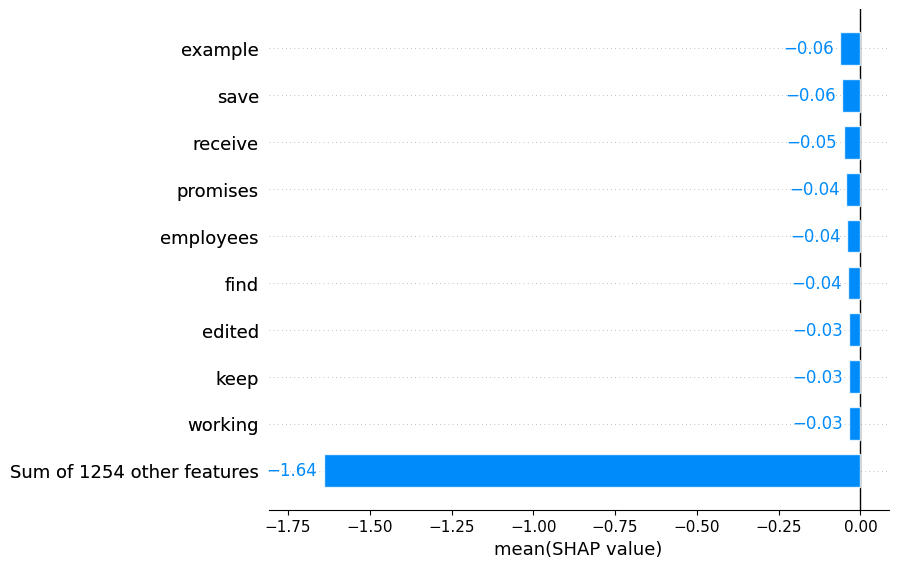

In [ ]:
shap.plots.bar(shap_values[:, :, "1"].mean(0))

## Shap values for a given event

In [ ]:
df = pd.read_csv('/content/cleaned_news_bias_dataset.csv', header=0)
print(df['event'].unique())

df_filtered = df[df['event'] == 'NorthKora']
print(df_filtered['event'].unique())
print(df_filtered.shape)

['Johnson' 'Facebook' 'NFL' 'NorthKora']
['NorthKora']
(11, 47)


In [ ]:
# Identify sentence and label columns
sentence_cols = [f's{i}' for i in range(20)]
label_cols = [f'{i}' for i in range(20)]

sentences_long = df_filtered.melt(
    id_vars=['id_article'],
    value_vars=sentence_cols,
    var_name='sentence_number',
    value_name='text'
)

labels_long = df_filtered.melt(
    id_vars=['id_article'],
    value_vars=label_cols,
    var_name='label_number',
    value_name='label'
)

sentences_long = sentences_long.sort_values(['id_article', 'sentence_number']).reset_index(drop=True)
labels_long = labels_long.sort_values(['id_article', 'label_number']).reset_index(drop=True)
combined_df = pd.concat([sentences_long, labels_long['label']], axis=1)

print(combined_df.shape)

combined_df.head()

(220, 4)


id_article sentence_number  \
0        36.0              s0   
1        36.0              s1   
2        36.0             s10   
3        36.0             s11   
4        36.0             s12   

                                                text  label  
0  tillerson makes n korea overture highlights cr...      2  
1  secretary state rex tillerson ready talk talki...      2  
2  begin lay map road map might willing work towards      1  
3  dont think realistic say going talk come table...      1  
4  north korea security watchers like van jackson...      2

In [ ]:
print(combined_df['text'].apply(type).value_counts())

nan_count = combined_df['text'].isna().sum()
print(f"Number of NaN entries in 'text' column: {nan_count}")

# Drop rows where 'text' is NaN
combined_df_cleaned = combined_df.dropna(subset=['text']).reset_index(drop=True)

nan_count_after = combined_df_cleaned['text'].isna().sum()
print(f"Number of NaN entries after cleaning: {nan_count_after}")

# Check for NaN in 'label' column
nan_labels = combined_df['label'].isna().sum()
print(f"Number of NaN labels: {nan_labels}")

def clean_text(text):
    # Use regex to remove patterns like [0]:, [1]:, etc., at the beginning of the string
    cleaned = re.sub(r'^\[\d+\]:\s*', '', text)
    return cleaned

# Apply the cleaning function to the 'text' column
combined_df_cleaned['text'] = combined_df_cleaned['text'].apply(clean_text)

for i in range(10):
  print(combined_df_cleaned.iloc[i]["sentence_number"])
  print(combined_df_cleaned.iloc[i]["text"])
  print(combined_df_cleaned.iloc[i]["label"])

# Map labels: 1->0, 2->1, 3->2, 4->3
combined_df_cleaned['label'] = combined_df_cleaned['label'] - 1
combined_df_cleaned['label'] = combined_df_cleaned['label'].astype(int)

print("Unique labels after mapping:", combined_df_cleaned['label'].unique())

text
<class 'str'>      214
<class 'float'>      6
Name: count, dtype: int64
Number of NaN entries in 'text' column: 6
Number of NaN entries after cleaning: 0
Number of NaN labels: 0
s0
tillerson makes n korea overture highlights credibility problem
2
s1
secretary state rex tillerson ready talk talking north korea
2
s10
begin lay map road map might willing work towards
1
s11
dont think realistic say going talk come table ready give program
1
s12
north korea security watchers like van jackson skeptical
2
s13
sort rolled eyes said jackson former asia specialist defense department new zealands victoria university wellington
2
s14
says posturing tillerson us cant effectively say wants talk goal complete verifiable denuclearization north korea
1
s15
pyongyang giving nuclear program nonstarter
1
s16
know north korea going go
2
s17
want actually negotiate something cant unrealistic goal jackson says
2
Unique labels after mapping: [1 0 2 3]


In [ ]:
print(combined_df_cleaned['label'].apply(type).value_counts())

train_val_df, test_df = train_test_split(
    combined_df_cleaned, test_size=0.2, random_state=42, stratify=combined_df_cleaned['label']
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

print("Unique labels in training set after mapping:", train_df['label'].unique())
print("Unique labels in validation set after mapping:", val_df['label'].unique())
print("Unique labels in test set after mapping:", test_df['label'].unique())

label
<class 'int'>    214
Name: count, dtype: int64
Training samples: 153
Validation samples: 18
Testing samples: 43
Unique labels in training set after mapping: [0 1 2 3]
Unique labels in validation set after mapping: [1 2 0]
Unique labels in test set after mapping: [2 1 0 3]


In [ ]:
# Convert to HuggingFace Datasets
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
shap_values = explainer(test_dataset["text"])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 3/43 [00:17<00:41,  1.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 5/43 [00:30<02:40,  4.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 10/43 [00:48<01:46,  3.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 13/43 [00:58<01:20,  2.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 15/43 [01:08<01:39,  3.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 16/43 [01:17<02:20,  5.22s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 17/43 [01:24<02:25,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 18/43 [01:32<02:38,  6.33s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 19/43 [01:38<02:28,  6.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 21/43 [01:52<02:20,  6.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 22/43 [02:02<02:38,  7.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 36/43 [02:38<00:10,  1.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 40/43 [02:54<00:07,  2.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 44it [03:13,  4.49s/it]


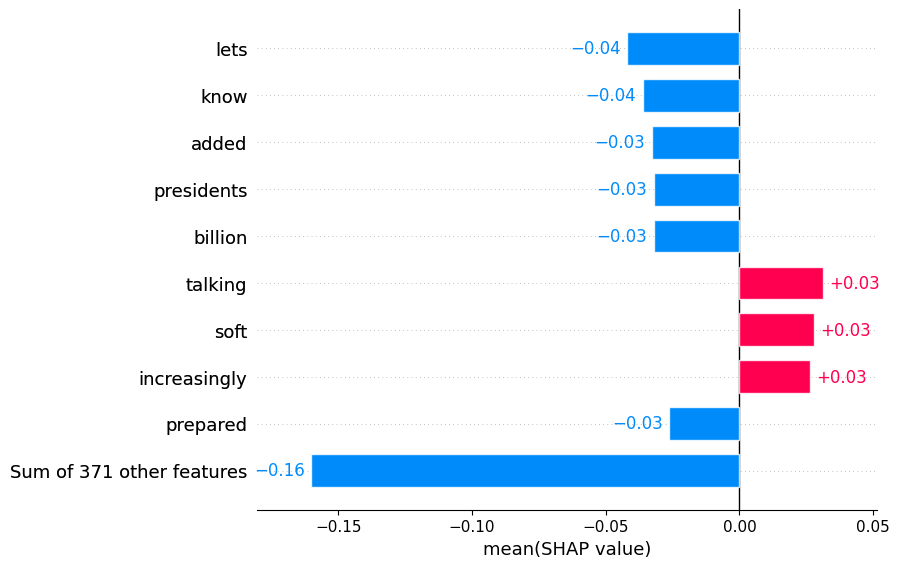

In [ ]:
shap.plots.bar(shap_values[:, :, "1"].mean(0))

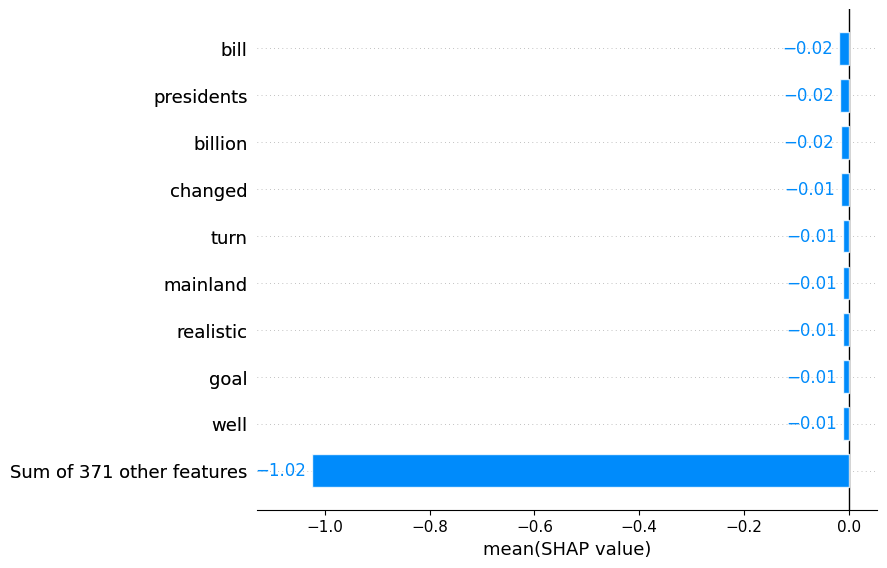

In [ ]:
shap.plots.bar(shap_values[:, :, "4"].mean(0))